# Regression of Used Car Prices

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import category_encoders as ce
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import torch
import torch.nn as nn
import torch.optim as optim

import shap
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression


In [22]:
data = pd.read_csv('train.csv')
data.head()


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


Рассмотрим столбцы:
1. id - совпадает с индексом нашей строки
2. brand - марка автомобиля
3. model - модель автомобиля
4. model_year - год выпуска
5. milage - пробег
6. fuel_type - тип топлива
7. engine - двигатель(мощность + объём + кол-во цилиндров + тип двигателя + тип топлива)
8. transmission - тип коробки передач
9. ext_col - цвет автомобиля
10. int_col - цвет салона
11. accident - информация о ДТП
12. clean_title - статус юридической чистоты автомобиля 
13. price - цена автомобиля

# Exploratiry Data Analysis

In [24]:
# Удалим столбец id
data = data.drop(columns = ['id'])
data.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [25]:
# Создадим список категориальных фичей
categorical_columns = data.select_dtypes(include=['object']).columns.to_list()
# Создадим список числовых фичей
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.difference(['price','id']).to_list()
# Создадим target с ценами автомобилей
target = 'price'

print("Categorical_columns:")
print(categorical_columns)
print("Numerical_columns:")
print(numerical_columns)

print()

Categorical_columns:
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Numerical_columns:
['milage', 'model_year']



# Data processing

In [26]:
# Посмотрим,сколько пропусков у нас в каждом признаке и какой процент от всех данных составляют пропуски
total_rows = len(data)
missing_counts = data.isnull().sum()
missing_percentage = (missing_counts / total_rows) * 100

missing_data = pd.DataFrame({
    'Feature': missing_counts.index,  # Название признаков
    'Missing Count': missing_counts.values,  # Количество пропусков
    'Missing Percentage': missing_percentage.values  # Процент пропусков
})

# Сортировка по убыванию количества пропусков
missing_data = missing_data.sort_values(by=['Missing Count', 'Missing Percentage'], ascending=False)
print(missing_data)

         Feature  Missing Count  Missing Percentage
10   clean_title          21419           11.360876
4      fuel_type           5083            2.696080
9       accident           2452            1.300568
0          brand              0            0.000000
1          model              0            0.000000
2     model_year              0            0.000000
3         milage              0            0.000000
5         engine              0            0.000000
6   transmission              0            0.000000
7        ext_col              0            0.000000
8        int_col              0            0.000000
11         price              0            0.000000


У нас пропуски в столбцах: clean_title(11%),fuel_type(2.7%) и accident(1.3%):
1. Пропуски в clean_title логичнее всего заполнить NO - то есть у автомобиля нет юридической чистоты,раз это не указано.
2. Пропущенные значения в fuel_type можем достать из столбца engine.
3. Пропуски в accident можно заполнить At least 1 accident or damage reported,раз не указано None reported,значит скорее всего были ДТП.

In [27]:
data['accident'] = data['accident'].fillna('At least 1 accident or damage reported')
data['clean_title'] = data['clean_title'].fillna('NO')

In [28]:
fuel_type_counts = data['fuel_type'].sort_values()

In [29]:
# Создадим функцию,которая в описании двигателя находит тип топлива
def findFuel(engine):
    mas = engine.split()
    for type in list(fuel_type_counts.index):
        if type in mas:
            return type
    return "unknown"

In [30]:
data['fuel_type'] = data.apply(
    lambda row: findFuel(row['engine']) if pd.isna(row['fuel_type']) else row['fuel_type'], axis=1
)

In [31]:
# Проверим,что заполнили все пропущенные значения
missing_counts = data.isna().sum().sum()
print(missing_counts)

0


Заполнили все пропуски в датасете.

In [32]:
# Преобразуем тип категориальных признаков в category
for feature in categorical_columns:
    data[feature] = data[feature].astype('category')

In [33]:
# Разделим наши данные на тренировочную и тестовую выборку
X = data.drop('price',axis = 1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [34]:
# Целевая кодировка категориальных признаков
target_encoder = ce.TargetEncoder(cols=categorical_columns)

In [35]:
# Обучаем кодировщик на тренировочных данных и применяем его
X_train_encoded = target_encoder.fit_transform(X_train, y_train)
X_test_encoded = target_encoder.transform(X_test)

In [36]:
# Масштабируем признаки
scaler = StandardScaler()
scaler.fit(X_train_encoded)

# Преобразуем обратно в DataFrame после масштабирования
X_train_encoded = pd.DataFrame(scaler.transform(X_train_encoded), columns=X_train.columns)
X_test_encoded = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test.columns)

In [37]:
def plot_y_test_vs_y_pred(y_test, y_pred, title='True vs Predicted Values'):
    """
    Строит график с истинными значениями (y_test) и предсказанными значениями (y_pred).

    Параметры:
    - y_test: array-like или pandas Series, истинные значения.
    - y_pred: array-like или pandas Series, предсказанные значения.
    - title: str, заголовок графика.
    """
    # Преобразование pandas Series в numpy массивы, если необходимо
    if isinstance(y_test, pd.Series):
        y_test = y_test.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values

    # Проверка, что длины y_test и y_pred совпадают
    if len(y_test) != len(y_pred):
        raise ValueError("Длины y_test и y_pred должны совпадать.")

    # Создание массива индексов для оси X
    x = np.arange(len(y_test))

    plt.figure(figsize=(15, 7))

    # Построение истинных значений (красные точки)
    plt.scatter(x, y_test, color='red', label='Истинные значения', alpha=0.6, edgecolors='w', s=50)

    # Построение предсказанных значений (синие точки)
    plt.scatter(x, y_pred, color='blue', label='Предсказанные значения', alpha=0.6, edgecolors='w', s=50)

    # Добавление линии тренда для истинных и предсказанных значений (опционально)
    # plt.plot(x, y_test, color='red', linestyle='-', alpha=0.5)
    # plt.plot(x, y_pred, color='blue', linestyle='--', alpha=0.5)

    # Добавление меток и заголовка
    plt.xlabel('Номер элемента', fontsize=14)
    plt.ylabel('Значение', fontsize=14)
    plt.title(title, fontsize=16)

    # Добавление легенды
    plt.legend(fontsize=12)

    # Добавление сетки для лучшей читаемости
    plt.grid(True, linestyle='--', alpha=0.5)

    # Опционально: Ограничение диапазона по оси X, если слишком много точек
    # plt.xlim(0, len(y_test))

    # Автоматическое расположение элементов для предотвращения наложения
    plt.tight_layout()

    # Отображение графика
    plt.show()


# LGBM

In [38]:
# Обучение модели LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
lgb_model.fit(X_train_encoded,
                y_train,
                eval_set=[(X_test_encoded, y_test)],
                callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1302
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 11
[LightGBM] [Info] Start training from score 43890.785316
Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 4.98856e+09
[20]	valid_0's l2: 4.77947e+09
[30]	valid_0's l2: 4.70298e+09
[40]	valid_0's l2: 4.67157e+09
[50]	valid_0's l2: 4.66496e+09
[60]	valid_0's l2: 4.66241e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's l2: 4.65967e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=1000,
              random_state=42)

In [39]:
# Предсказания для LightGBM
lgb_predictions = lgb_model.predict(X_test_encoded)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))
print(f'RMSE для LightGBM: {lgb_rmse}')

RMSE для LightGBM: 68250.10540409038


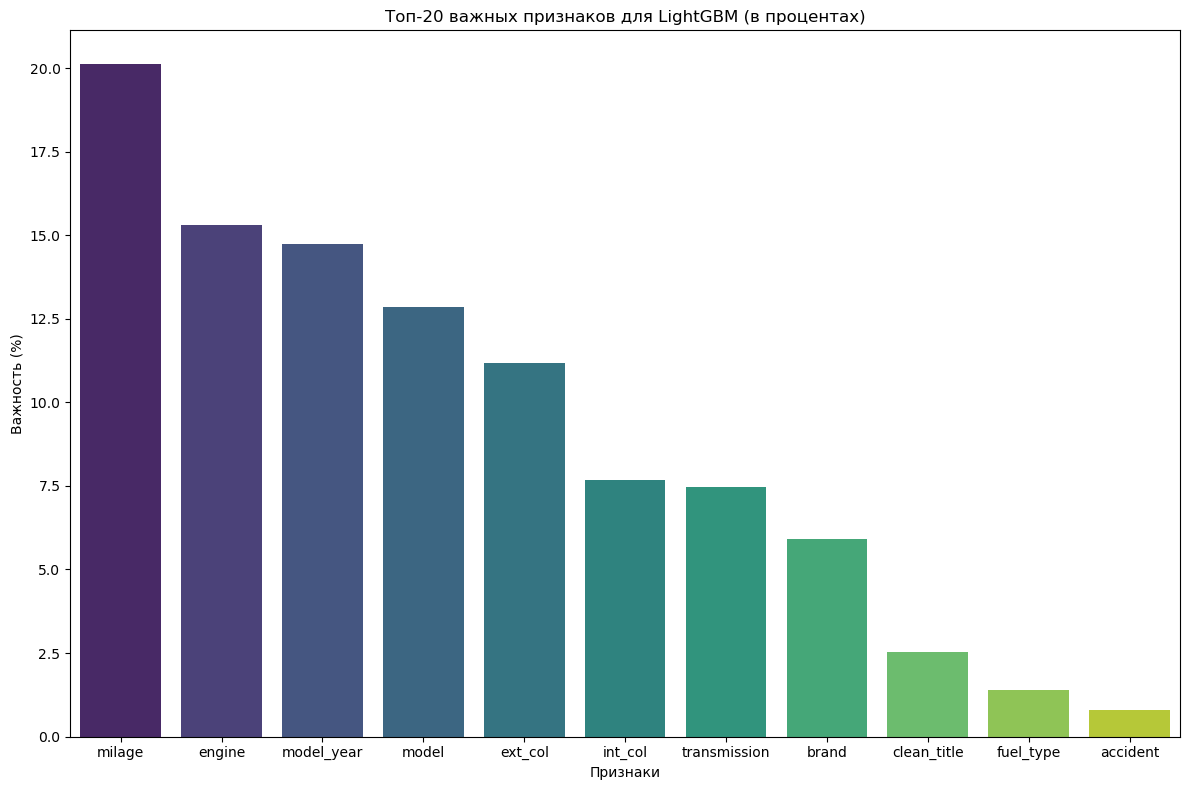

In [40]:
# Получение важности признаков
feature_importances = lgb_model.feature_importances_
feature_names = X_train_encoded.columns

# Создание DataFrame с важностями признаков
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
})

# Вычисление процентной важности
importance_df['Важность (%)'] = 100 * (importance_df['Важность'] / importance_df['Важность'].sum())

# Сортировка признаков по убыванию процентной важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Отображение важности признаков в процентах
plt.figure(figsize=(12, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')


plt.title("Топ-20 важных признаков для LightGBM (в процентах)")
plt.xlabel("Признаки")
plt.ylabel("Важность (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

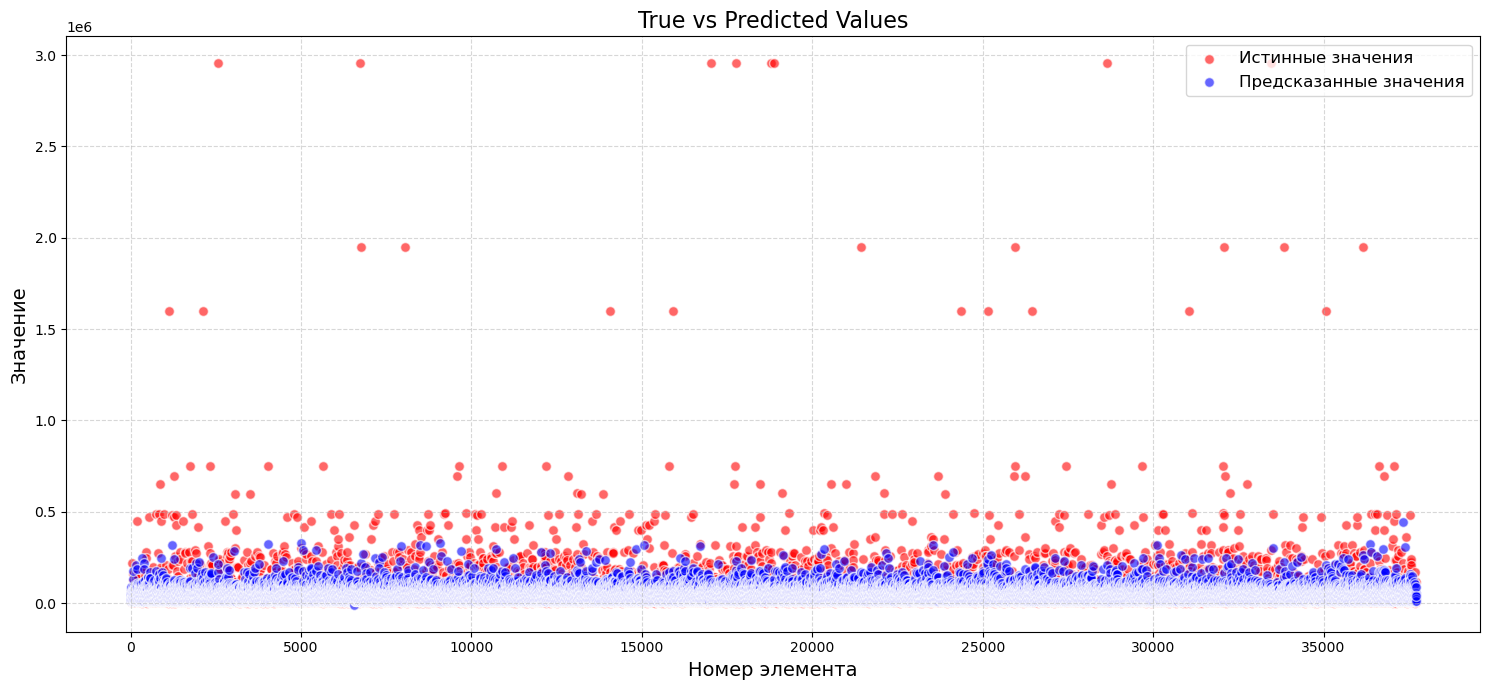

In [41]:
plot_y_test_vs_y_pred(y_test,lgb_predictions)

# XGBoost

In [42]:
print(xgb.__version__)

2.1.1


In [43]:
# Инициализация модели
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    random_state=42,
    early_stopping_rounds=100
)

# Обучение модели с ранней остановкой
xgb_model.fit(
    X_train_encoded, y_train,
    eval_set=[(X_test_encoded, y_test)],
    # early_stopping_rounds=100,  # Используем правильный параметр
    verbose=True
)

[0]	validation_0-rmse:73978.40083
[1]	validation_0-rmse:73445.06674
[2]	validation_0-rmse:72955.40026
[3]	validation_0-rmse:72519.43637
[4]	validation_0-rmse:72141.49090
[5]	validation_0-rmse:71795.76155
[6]	validation_0-rmse:71510.69717
[7]	validation_0-rmse:71250.82893
[8]	validation_0-rmse:71029.46070
[9]	validation_0-rmse:70803.16462
[10]	validation_0-rmse:70626.40472
[11]	validation_0-rmse:70474.72052
[12]	validation_0-rmse:70306.02064
[13]	validation_0-rmse:70178.94592
[14]	validation_0-rmse:70047.80282
[15]	validation_0-rmse:69933.18808
[16]	validation_0-rmse:69838.70919
[17]	validation_0-rmse:69752.42765
[18]	validation_0-rmse:69671.20113
[19]	validation_0-rmse:69610.08373
[20]	validation_0-rmse:69562.54193
[21]	validation_0-rmse:69540.47854
[22]	validation_0-rmse:69509.55784
[23]	validation_0-rmse:69486.31639
[24]	validation_0-rmse:69495.59925
[25]	validation_0-rmse:69496.66994
[26]	validation_0-rmse:69498.90421
[27]	validation_0-rmse:69461.84299
[28]	validation_0-rmse:69473.1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [44]:
# Предсказания для XGBoost
xgb_predictions = xgb_model.predict(X_test_encoded)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f'RMSE для XGBoost: {xgb_rmse}')

RMSE для XGBoost: 69461.84283260444


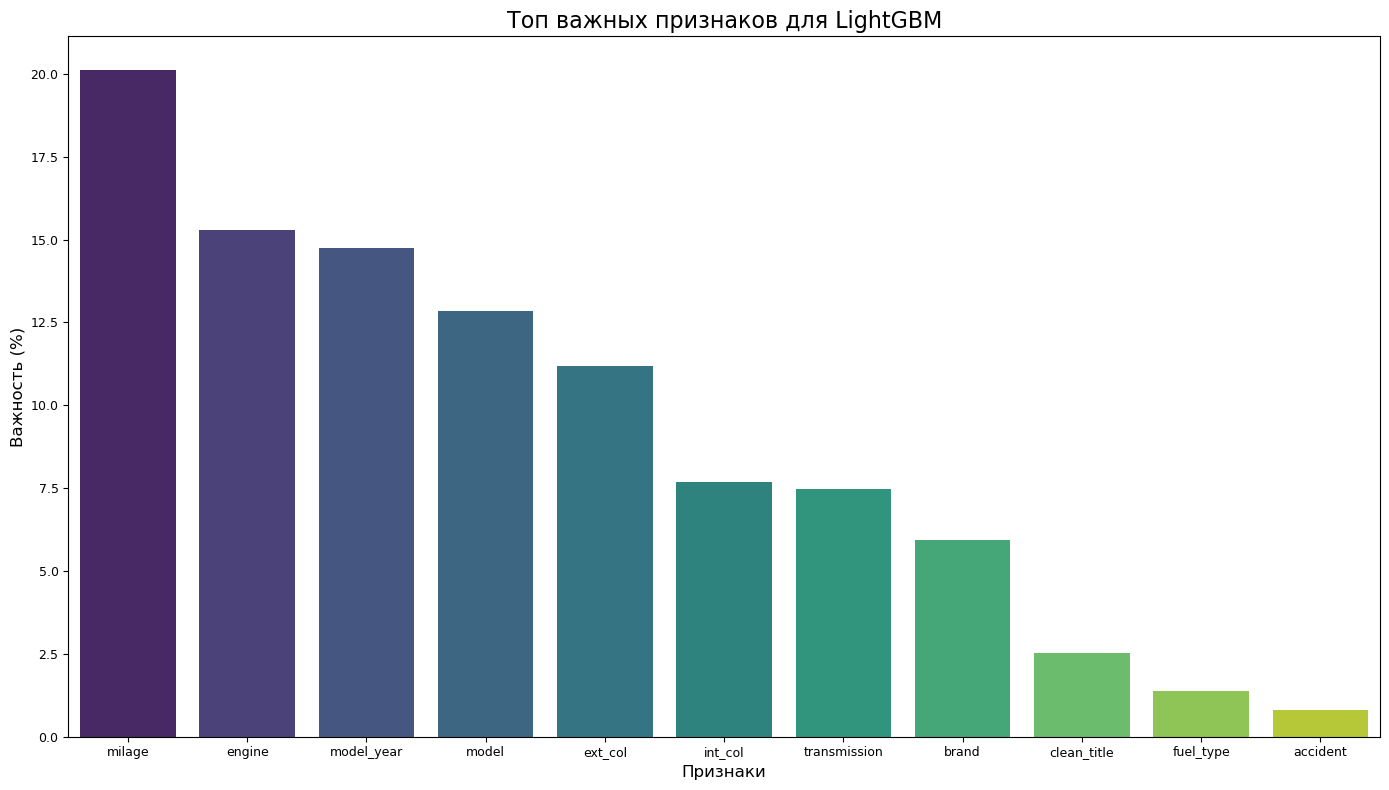

In [45]:
# Получение важности признаков
feature_importances = lgb_model.feature_importances_
feature_names = X_train_encoded.columns

# Создание DataFrame с важностями признаков
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
})

# Вычисление процентной важности
importance_df['Важность (%)'] = 100 * (importance_df['Важность'] / importance_df['Важность'].sum())

# Сортировка признаков по убыванию процентной важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Отображение важности признаков в процентах с вертикальными столбцами
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')


plt.title("Топ важных признаков для LightGBM", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

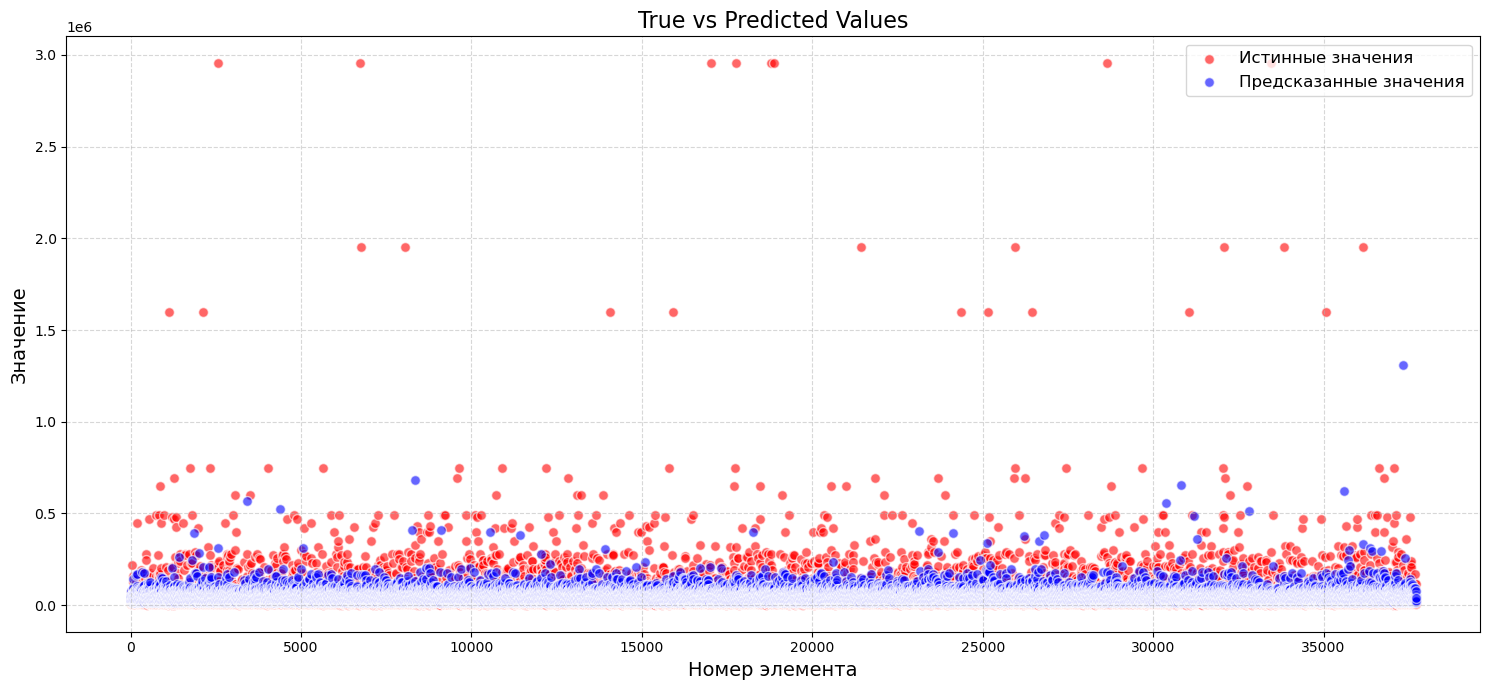

In [46]:
plot_y_test_vs_y_pred(y_test,xgb_predictions)

# Linear Regression

In [47]:
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

LinearRegression()

In [48]:
# Предсказания для XGBoost
lr_predictions = lr_model.predict(X_test_encoded)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
print(f'RMSE для LinearRegression: {lr_rmse}')

RMSE для LinearRegression: 68776.1761427296


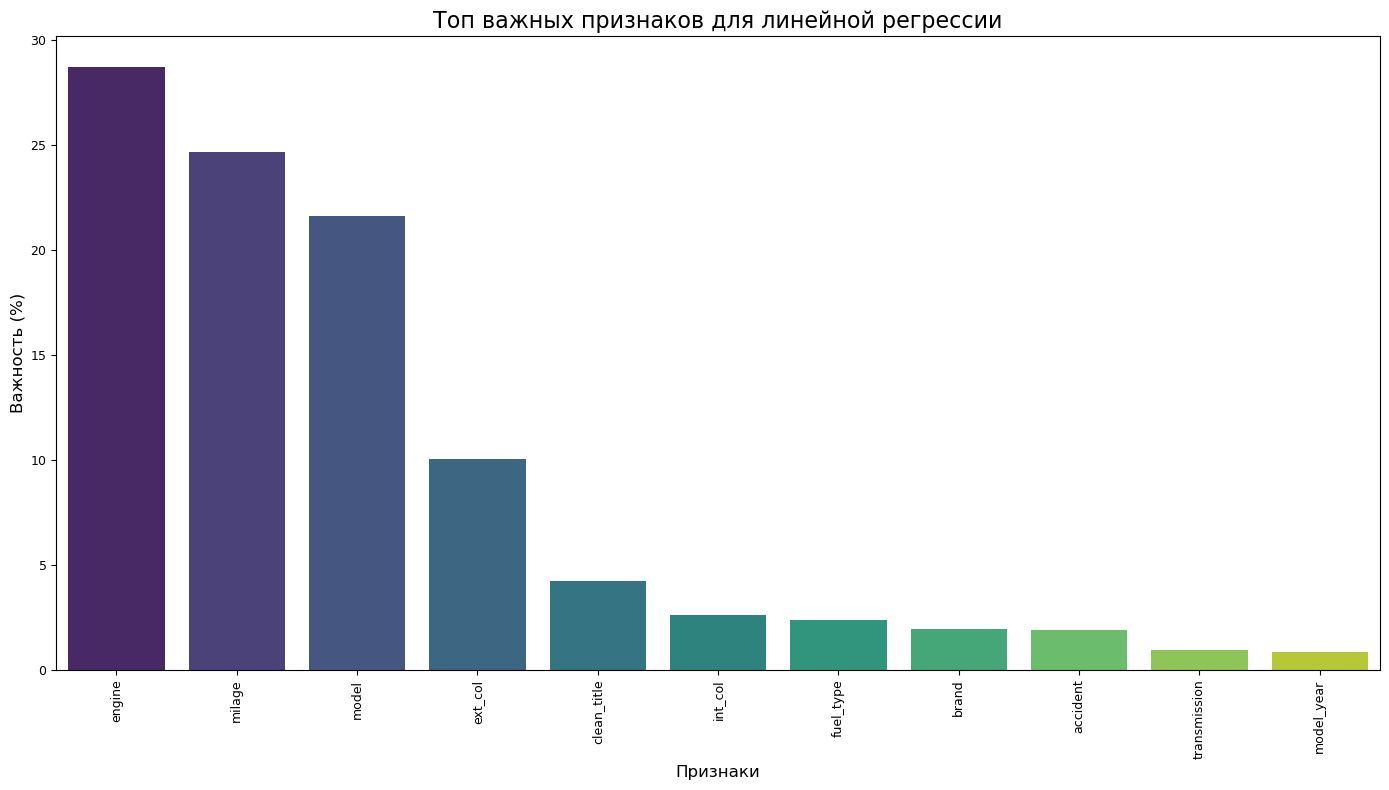

In [49]:
# 3. Получение коэффициентов модели
coefficients = lr_model.coef_

# 4. Вычисление абсолютных значений коэффициентов для важности
importance = np.abs(coefficients)

# 5. Преобразование важности в проценты
importance_percentage = 100 * (importance / importance.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# 6. Построение вертикального столбчатого графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

plt.title("Топ важных признаков для линейной регрессии", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

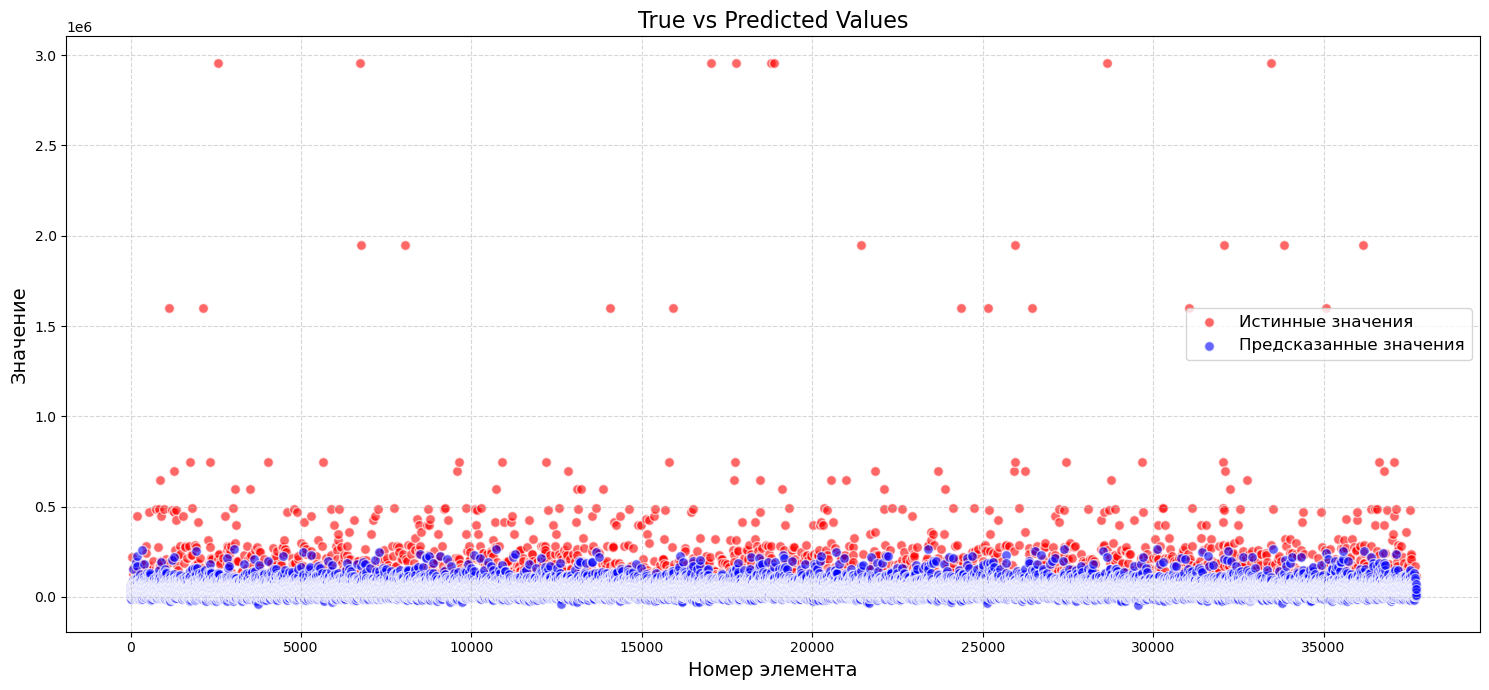

In [50]:
plot_y_test_vs_y_pred(y_test,lr_predictions)

# Ridge

In [51]:
ridge_model = Ridge()
ridge_model.fit(X_train_encoded, y_train)

Ridge()

In [52]:
# Предсказания для XGBoost
ridge_predictions = ridge_model.predict(X_test_encoded)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predictions))
print(f'RMSE для Ridge: {ridge_rmse}')

RMSE для Ridge: 68776.17378323237


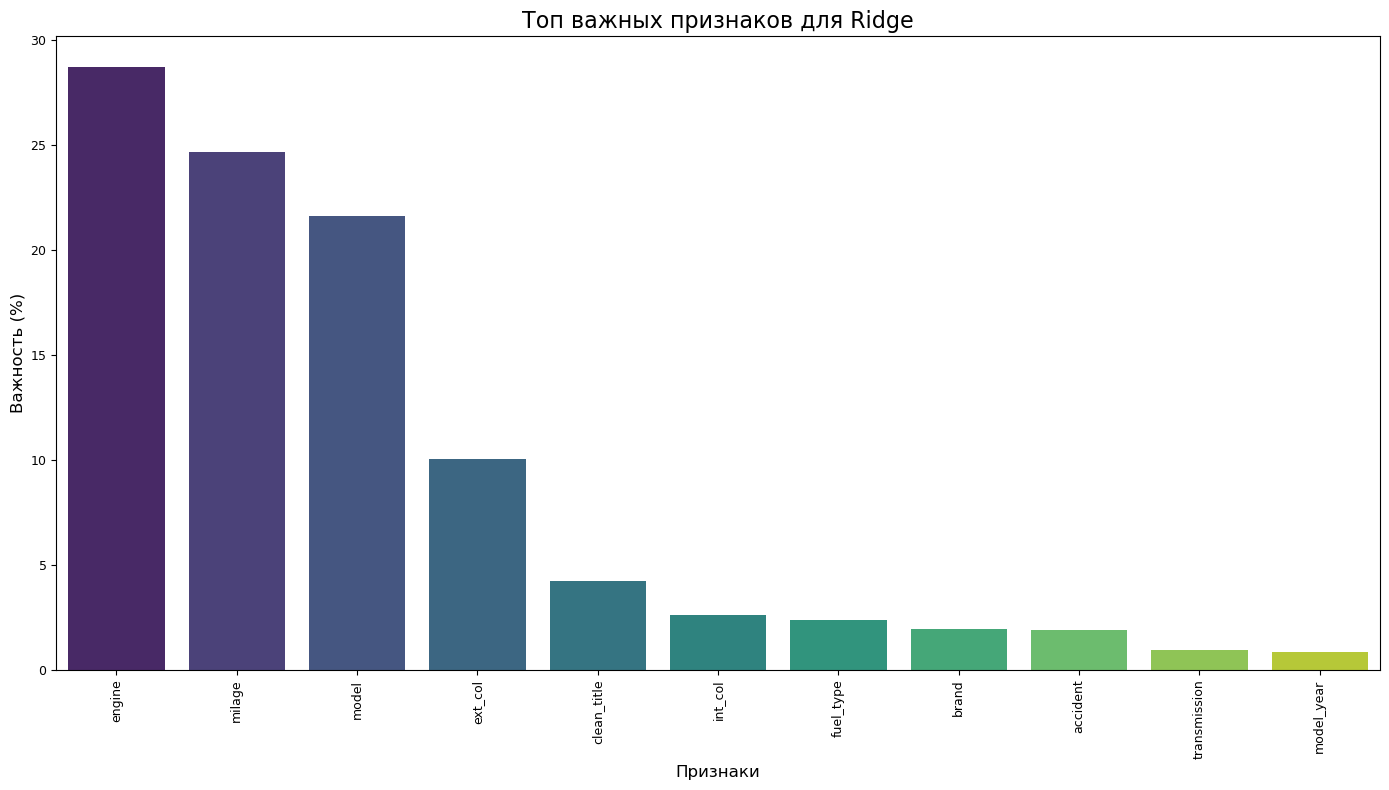

In [53]:
# 3. Получение коэффициентов модели
coefficients = ridge_model.coef_

# 4. Вычисление абсолютных значений коэффициентов для важности
importance = np.abs(coefficients)

# 5. Преобразование важности в проценты
importance_percentage = 100 * (importance / importance.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# 6. Построение вертикального столбчатого графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

plt.title("Топ важных признаков для Ridge", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

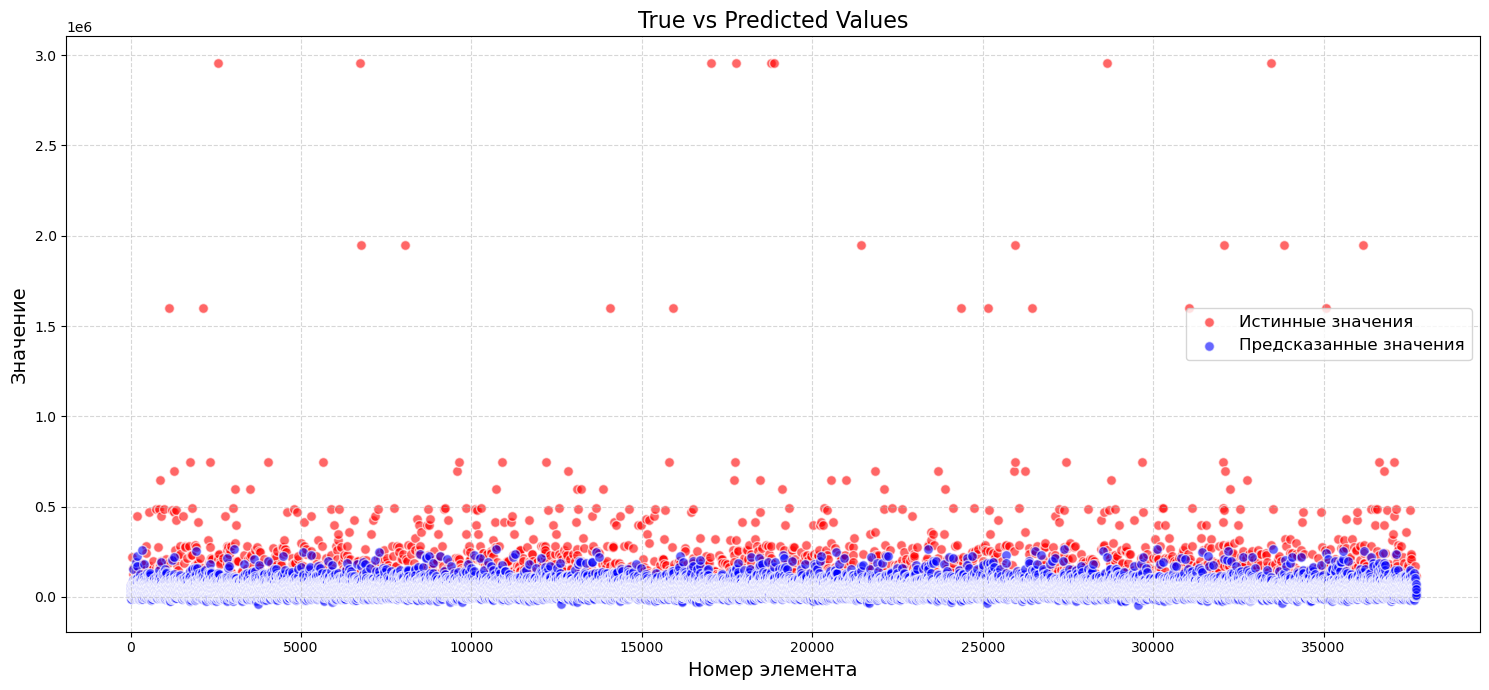

In [54]:
plot_y_test_vs_y_pred(y_test,ridge_predictions)

# RandomForest

In [55]:

rf_model = RandomForestRegressor(
    n_estimators=100,          # Количество деревьев в лесу
    max_depth=None,            # Максимальная глубина дерева
    random_state=42,           # Для воспроизводимости результатов
    n_jobs=-1                  # Использовать все доступные ядра процессора
)
rf_model.fit(X_train_encoded, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [56]:
# Предсказания для RandomForestRegressor
rf_predictions = rf_model.predict(X_test_encoded)

# Оценка модели с использованием RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f'RMSE для RandomForestRegressor: {rf_rmse}')

RMSE для RandomForestRegressor: 74137.4275050916


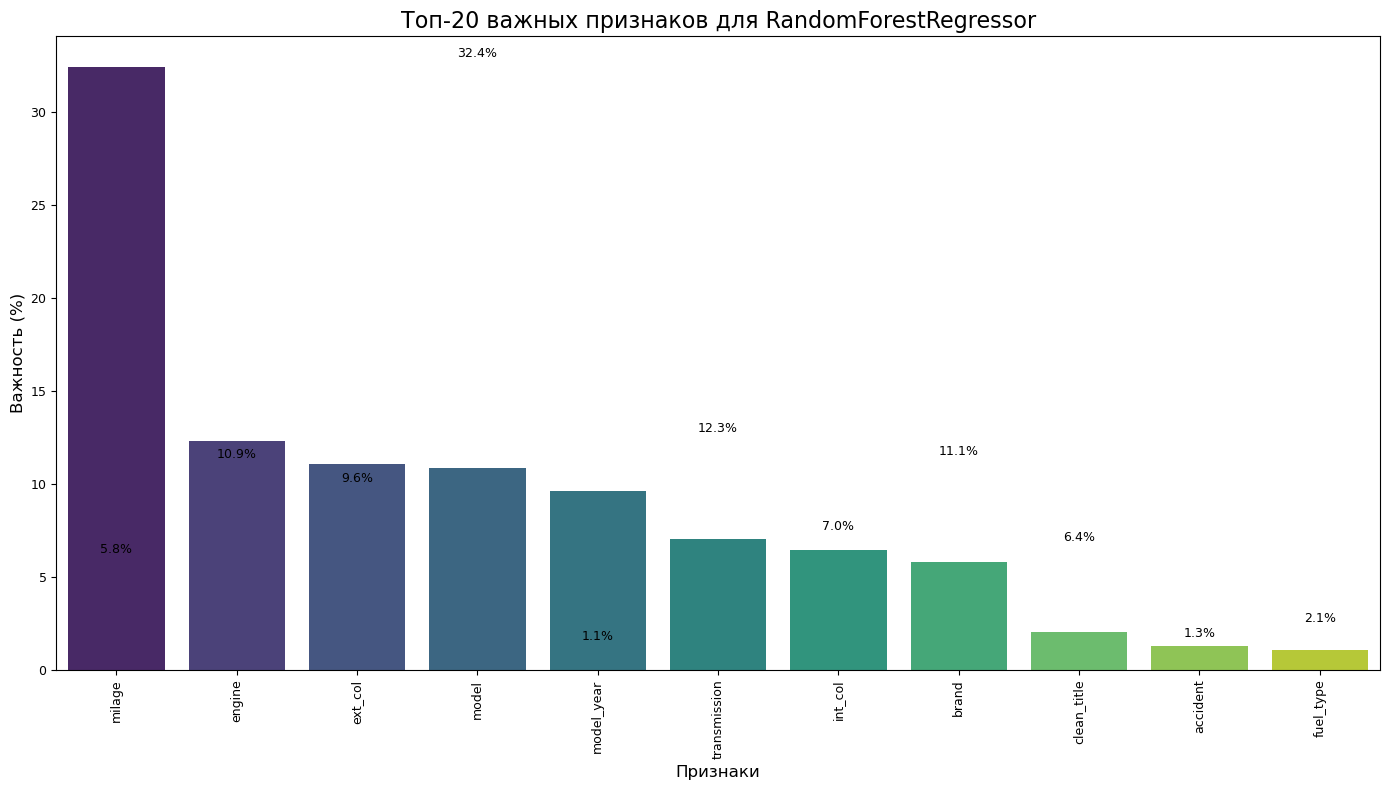

In [57]:
# Получение важности признаков
feature_importances = rf_model.feature_importances_

# Преобразование важности в проценты
importance_percentage = 100 * (feature_importances / feature_importances.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X_train_encoded.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Построение вертикального столбчатого графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

# Добавление процентных значений над столбиками
for index, row in importance_df.iterrows():
    plt.text(
        x=index,
        y=row['Важность (%)'] + 0.5,  # Немного выше вершины столбика
        s=f"{row['Важность (%)']:.1f}%",
        ha='center',
        fontsize=9
    )

plt.title("Топ-20 важных признаков для RandomForestRegressor", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

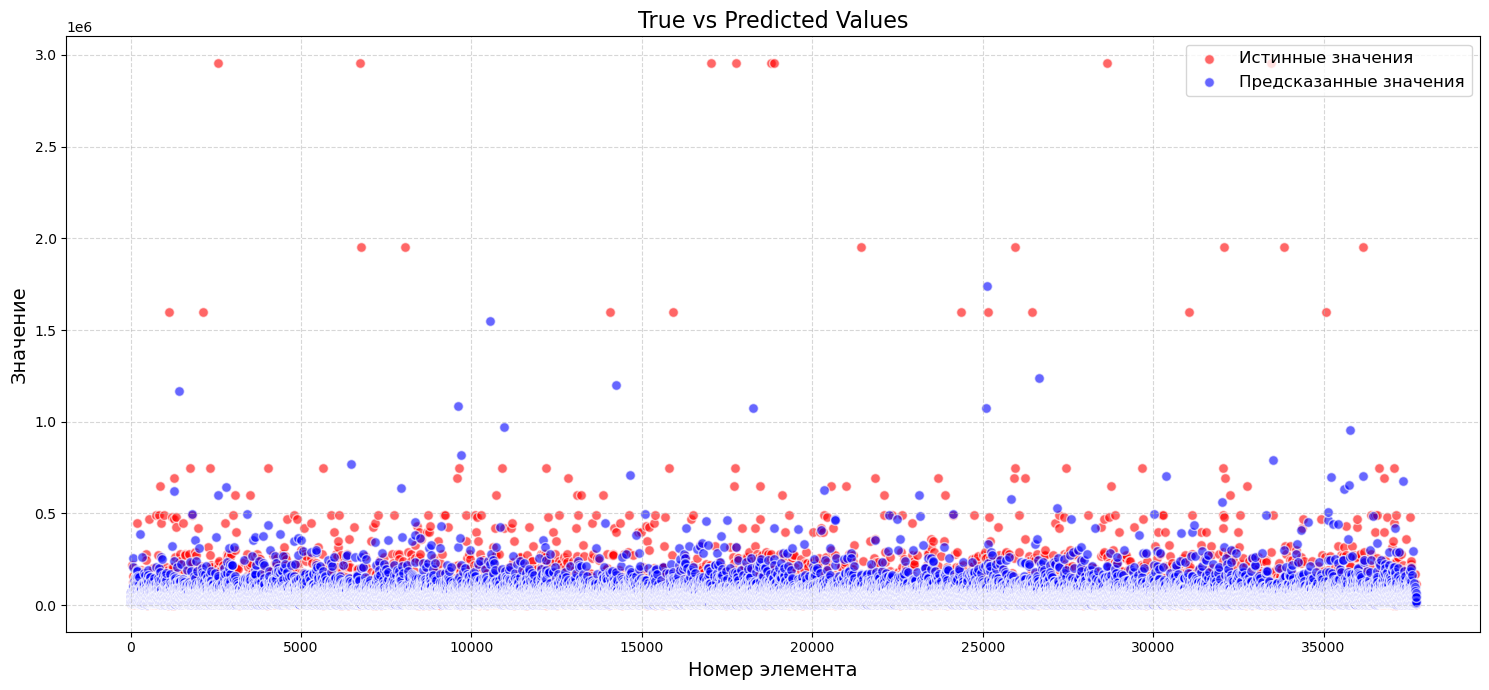

In [58]:
plot_y_test_vs_y_pred(y_test,rf_predictions)

#  NeuralNetworks

In [59]:
# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
# Конвертируем данные в тензоры
X_train_tensor = torch.tensor(X_train_encoded.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_encoded.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)


In [61]:
# Функция для создания мини-батчей
def create_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

## 1 model

In [62]:
class CarPricePredictor1(nn.Module):
    def __init__(self, input_dim):
        super(CarPricePredictor1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(32, 16)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(16, 1)
        self.activation1 = nn.ReLU()


    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation1(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [63]:
# Инициализируем модель
input_dim = X_train_encoded.shape[1]  # Количество признаков
model = CarPricePredictor1(input_dim).to(device)

In [64]:
# Определим функцию потерь и оптимизатор
criterion = nn.MSELoss()  # Функция потерь для задачи регрессии (MSE)
optimizer = optim.Adam(model.parameters(), lr=0.03,weight_decay=1e-5)  # Оптимизатор Adam

In [65]:
# Обучение модели
num_epochs = 500
batch_size = 10000
patience = 20


In [66]:
for epoch in range(num_epochs):
    model.train()  # Установим модель в режим тренировки
    epoch_loss = 0
    total_samples = 0
    for X_batch, y_batch in create_batches(X_train_tensor, y_train_tensor, batch_size):
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = model(X_batch)  # Прямой проход
        loss = criterion(outputs, y_batch)  # Вычисляем ошибку
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем веса
        batch_size_actual = X_batch.size(0)
        epoch_loss += loss.item() * batch_size_actual  # Суммируем потери, умноженные на размер батча
        total_samples += batch_size_actual

    # Вычисляем средний MSE и RMSE за эпоху
    epoch_mse = epoch_loss / total_samples
    epoch_rmse = np.sqrt(epoch_mse)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], RMSE: {epoch_rmse:.4f}')

Epoch [10/500], RMSE: 75887.6545
Epoch [20/500], RMSE: 75343.7327
Epoch [30/500], RMSE: 74945.7005
Epoch [40/500], RMSE: 75111.5589
Epoch [50/500], RMSE: 75000.1764
Epoch [60/500], RMSE: 75015.3407
Epoch [70/500], RMSE: 75162.8554
Epoch [80/500], RMSE: 75014.7610
Epoch [90/500], RMSE: 75078.8725
Epoch [100/500], RMSE: 75103.3854
Epoch [110/500], RMSE: 74928.8549
Epoch [120/500], RMSE: 75052.2413
Epoch [130/500], RMSE: 74999.6265
Epoch [140/500], RMSE: 74951.0505
Epoch [150/500], RMSE: 74961.0901
Epoch [160/500], RMSE: 74897.7626
Epoch [170/500], RMSE: 75042.5892
Epoch [180/500], RMSE: 74867.8580
Epoch [190/500], RMSE: 74985.7909
Epoch [200/500], RMSE: 74840.2406
Epoch [210/500], RMSE: 74976.8829
Epoch [220/500], RMSE: 74842.3921
Epoch [230/500], RMSE: 75000.8273
Epoch [240/500], RMSE: 74959.1730
Epoch [250/500], RMSE: 74934.8248
Epoch [260/500], RMSE: 74823.9674
Epoch [270/500], RMSE: 74828.0377
Epoch [280/500], RMSE: 74828.7469
Epoch [290/500], RMSE: 74961.4897
Epoch [300/500], RMSE: 

In [67]:
# Оценка модели на тестовых данных
model.eval()  # Установим модель в режим оценки
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

    # Вычисляем RMSE
    train_rmse = mean_squared_error(y_train_tensor.cpu(), y_pred_train.cpu(), squared=False)
    test_rmse = mean_squared_error(y_test_tensor.cpu(), y_pred_test.cpu(), squared=False)

    print(f'Train RMSE: {train_rmse:.4f}')
    print(f'Test RMSE: {test_rmse:.4f}')

Train RMSE: 73519.2109
Test RMSE: 68160.7344


In [68]:
# Обертываем модель в класс, совместимый с scikit-learn
class SklearnWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # Модель уже обучена; этот метод можно оставить пустым
        pass

    def predict(self, X):
        # Преобразуем данные в тензор и перемещаем на устройство
        X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X_tensor).cpu().numpy()
        return predictions.flatten()  # Преобразуем в одномерный массив


         Признак  Важность (%)
3         milage     48.866943
5         engine     24.562784
1          model     13.677883
2     model_year      7.428688
9       accident      1.831869
7        ext_col      1.737721
6   transmission      0.616191
10   clean_title      0.591940
0          brand      0.467677
8        int_col      0.117470
4      fuel_type      0.100834


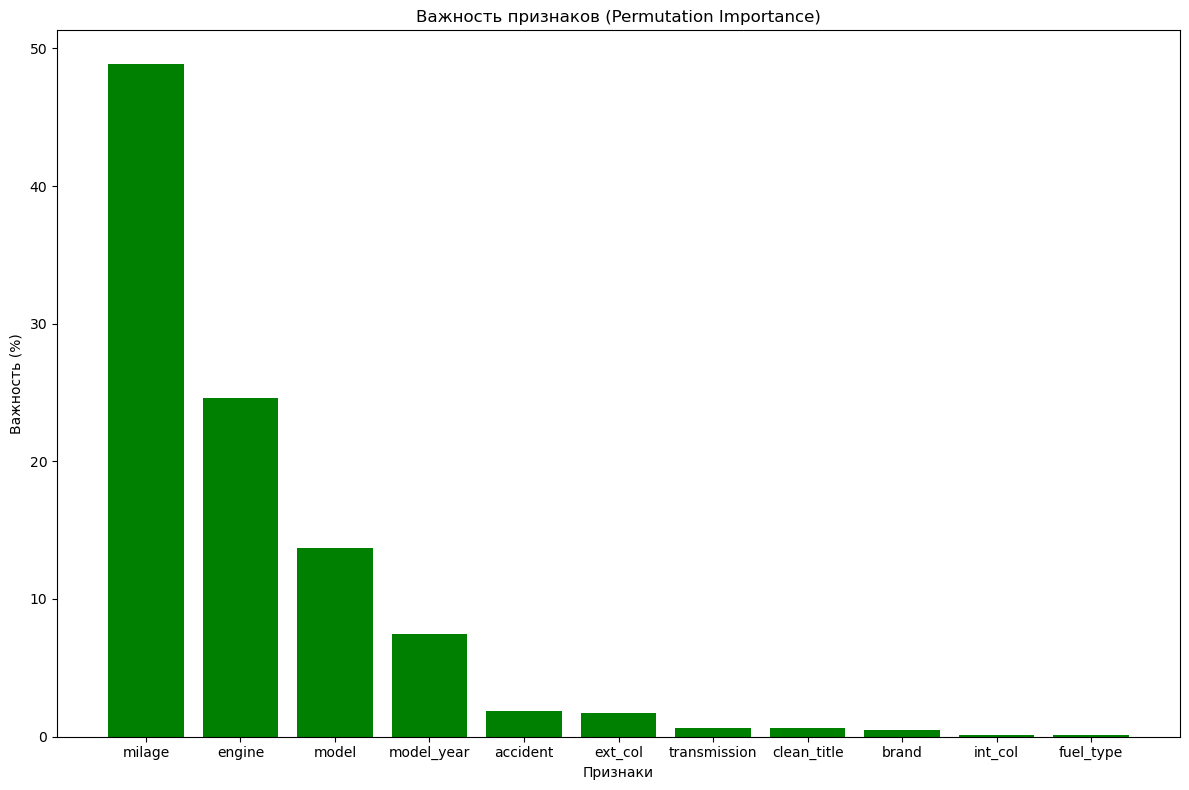

In [69]:
# Создаем экземпляр обертки
wrapped_model = SklearnWrapper(model)

# Используем permutation_importance
result = permutation_importance(
    estimator=wrapped_model,
    X=X_test_encoded,
    y=y_test,
    scoring='neg_root_mean_squared_error',  # Используем RMSE
    n_repeats=10,
    random_state=42
)

# Получаем важности признаков
feature_importances = result.importances_mean

# Вычисляем процентную важность
feature_importances_percent = 100 * feature_importances / np.sum(feature_importances)

# Создаем DataFrame с результатами
importance_df = pd.DataFrame({
    'Признак': X_test_encoded.columns,
    'Важность (%)': feature_importances_percent
})

# Сортируем по важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)

# Отображаем результаты
print(importance_df)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
plt.bar(importance_df['Признак'], importance_df['Важность (%)'], color='green')

plt.xlabel('Признаки')
plt.ylabel('Важность (%)')
plt.title('Важность признаков (Permutation Importance)')
plt.xticks(rotation=0)  # Поворачиваем подписи на оси X, чтобы они не накладывались
plt.tight_layout()
plt.show()



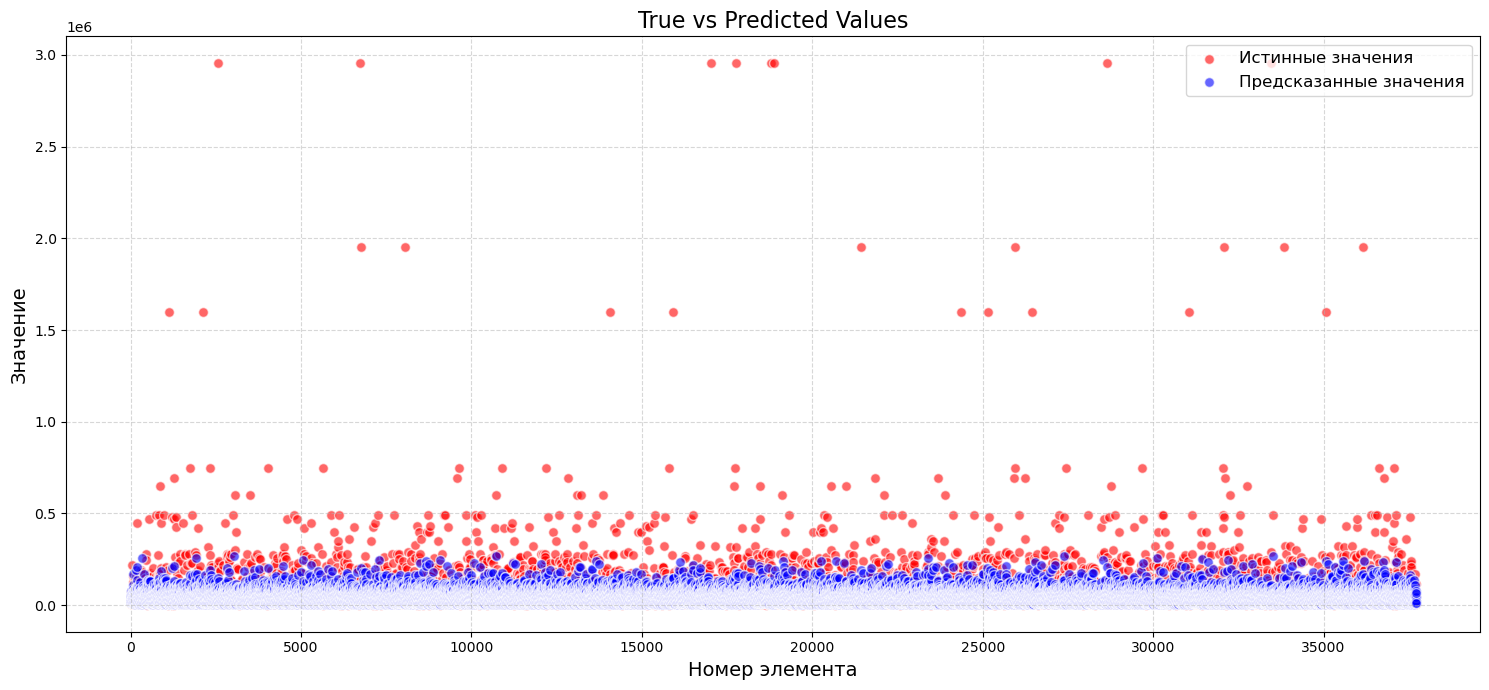

In [70]:
plot_y_test_vs_y_pred(y_test,y_pred_test)

# SVR


In [71]:
# Создаем экземпляр модели SVR с параметрами по умолчанию
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Обучаем модель на тренировочных данных
svr_model.fit(X_train_encoded, y_train)


SVR()

In [72]:
# Предсказания на тестовых данных
y_pred_svr = svr_model.predict(X_test_encoded)

rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
print(f'SVR RMSE на тестовых данных: {rmse_svr:.4f}')

SVR RMSE на тестовых данных: 73871.4098


milage          0.643560
engine          0.588035
model_year      0.544313
transmission    0.438428
model           0.418917
clean_title     0.160114
brand           0.152969
ext_col         0.130777
int_col         0.127387
accident        0.054207
fuel_type       0.032242
dtype: float64


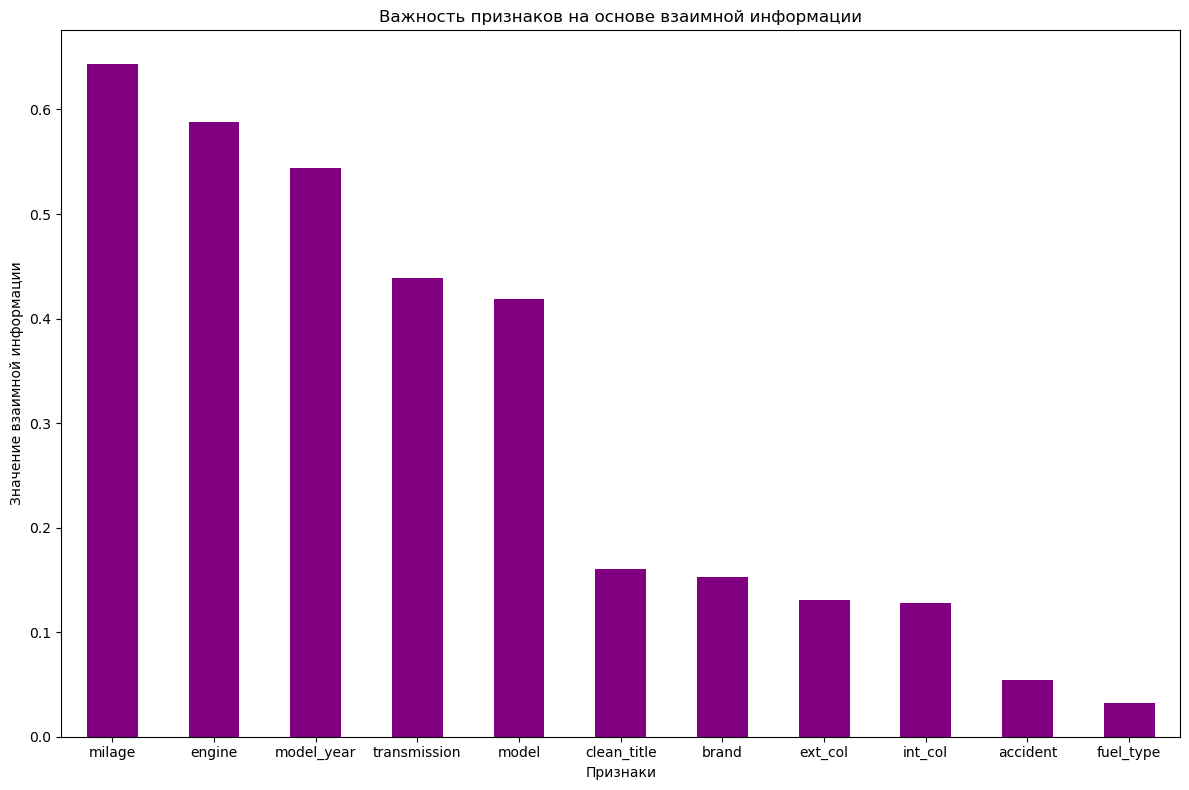

In [75]:
# Вычисляем взаимную информацию между признаками и целевой переменной
mi_scores = mutual_info_regression(X_train_encoded, y_train, random_state=42)

# Создаем Series для удобства
mi_scores = pd.Series(mi_scores, index=X_train_encoded.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Отображаем результаты
print(mi_scores)

# Визуализация
plt.figure(figsize=(12, 8))
mi_scores.plot.bar(color='purple')
plt.title('Важность признаков на основе взаимной информации')
plt.ylabel('Значение взаимной информации')
plt.xlabel('Признаки')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

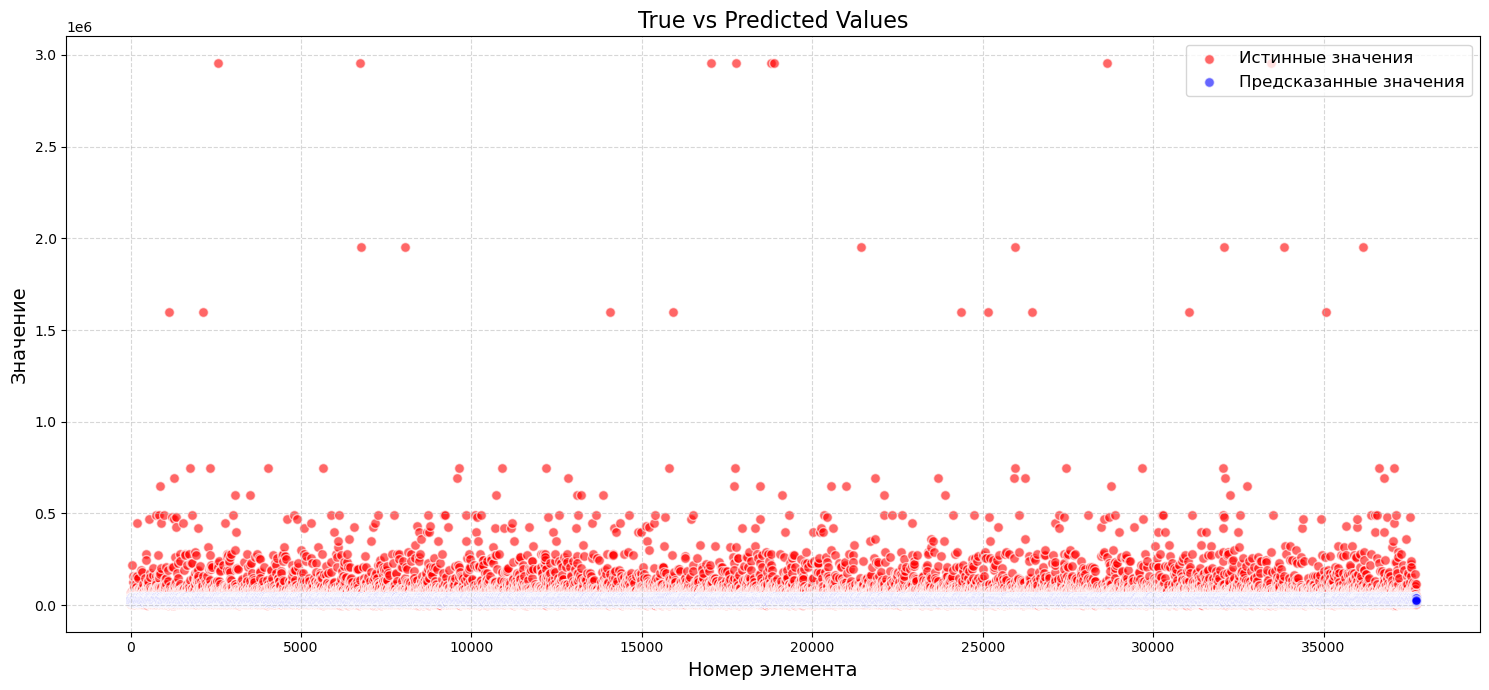

In [74]:
plot_y_test_vs_y_pred(y_test,y_pred_svr)